In [1]:
from classes.Point import *
import pandas
from pyproj import Proj
import matplotlib.pyplot as plt

### Load data

In [2]:
settlements = pandas.concat(
    map(
        pandas.read_csv,
        [
            'datasets/towns.csv',
            'datasets/cities.csv',
            'datasets/villages.csv'
        ]
    ),
    ignore_index = True
)

### Modify data

In [3]:
# Rename callret-3 column to population
settlements.rename(
    columns = { 'callret-3': 'population' },
    inplace = True
)

### Extend data

In [4]:
# Calculate radii of settlements
settlements['radius'] = settlements.apply(
    lambda row:
        math.sqrt(
            row['area'] / math.pi
        ),
    axis = 1
)

In [5]:
# Calculate densities of settlements
settlements['density'] = settlements.apply(
    lambda row:
        row['population'] / (row['area'] / 1000000),
    axis = 1
)

### Transform data

In [6]:
# Convert geographic settlements coords to x, y coords
projection = Proj(
    proj = 'utm',
    zone = 34,
    ellps = 'WGS84',
    preserve_units = False
)
x, y = projection(
    tuple(settlements.long),
    tuple(settlements.lat)
)
xs, ys = list(x), list(y)
xmin, ymin = min(xs), min(ys)
settlements['x'] = [ x - xmin for x in xs ]
settlements['y'] = [ y - ymin for y in ys ]

### Plot settlements

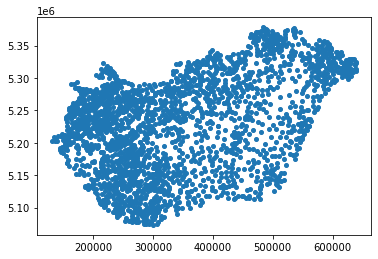

In [7]:
plt.plot(xs, ys, 'o', markersize = 4)
plt.show()